# Basket Option Pricing Model

## Importing Libraries

In [1]:
import numpy as np 
import scipy.stats as sps 
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
import torch
import torch.distributions as dist
import time

## Pricing a Call on a Basket of Assets Using Adaptive Monte Carlo

To price a European call option on a basket of correlated assets, we use an **adaptive Monte Carlo approach**.  
The method dynamically increases the number of simulations until the confidence interval width is below a target precision $ \epsilon $.

### 1. Generation of Correlated Random Variables

- For each batch, we simulate **independent standard normal variables** for each asset and each path.  
- Using the **Cholesky decomposition** of the correlation matrix, we transform these variables into **correlated standard normals**:
$$
Z_\text{corr} = Z \, L^\top,
$$
where $ L $ is the lower-triangular matrix such that $ \text{Corr} = L L^\top $.

### 2. Simulation of Asset Prices at Maturity

- Under the **Black–Scholes dynamics**, the price of each asset at maturity is:
$$
S_T^i = S_0^i \, \exp\Big((r - 0.5 \sigma_i^2) T + \sigma_i \sqrt{T} \, Z_\text{corr}^i\Big)
$$
for each asset $ i = 1, \dots, d $, where $ r $ is the risk-free rate and $ \sigma_i $ the volatility.

### 3. Basket Payoff Computation

- The payoff of a call on the basket is:
$$
h(S_T^1, \dots, S_T^d) = \Big(\frac{1}{d} \sum_{i=1}^{d} S_T^i - K \Big)^+
$$
- Each payoff is then **discounted** at the risk-free rate:
$$
\text{Call}_{Basket} = e^{-rT} \, h(S_T^1, \dots, S_T^d)
$$

### 4. Adaptive Simulation Loop

- The Monte Carlo estimator after $ n $ samples is:
$$
\hat{V}_n = \frac{1}{n} \sum_{j=1}^{n} \text{Call}_{Basket_j}
$$
- The half-width of the confidence interval at confidence level $ 1-\alpha $ is:
$$
\text{CI}_{1-\alpha/2} = z_{1-\alpha/2} \, \frac{\hat{\sigma}_\text{payoff}}{\sqrt{n}}
$$
- The algorithm iteratively **adds new batches of simulations** until:
$$
\text{CI}_{1-\alpha/2} \leq \epsilon
$$
where $ \epsilon $ is the desired precision and $ z_{1-\alpha/2} $ the quantile of the standard normal distribution.

### 5. Final Estimation and Confidence Interval

- Once the stopping criterion is reached, the option price is given by the **mean of all simulated discounted payoffs**:
$$
\text{Price} = \hat{V}_n
$$
- The **confidence interval** for the estimate is:
$$
[\hat{V}_n - \text{CI}_{1-\alpha/2}, \; \hat{V}_n + \text{CI}_{1-\alpha/2}]
$$
- The algorithm also outputs the **total number of simulations** and the **computation time**, ensuring the desired accuracy is met efficiently.


In [2]:
def simulate_paths(n_paths, L_cor):
    """Generate correlated Gaussian vectors based on the correlation matrix 'cor'."""
    d = cor.shape[0]
    G = rng.normal(size=(n_paths, d))
    return G @ L_cor.T


def payoff_basket(S0, K, r, t, sigma, G_corr):
    """Compute the payoff of the basket option."""
    S0 = np.array(S0)
    sigma = np.array(sigma)
    St = S0 * np.exp((r - 0.5 * sigma ** 2) * t + np.sqrt(t) * G_corr * sigma)
    payoff = np.maximum(np.mean(St, axis=1) - K, 0)
    return np.exp(-r * t) * payoff 


def basket_mc(S0, K, r, t, cor, sigma, rng, e, proba, batch_size=1_000_000):
    """
    Adaptive Monte Carlo pricing for a basket option.
    The number of samples increases until the confidence interval width
    is smaller than the target precision 'e'.
    """
    start = time.perf_counter()

    n_total = 0
    z = sps.norm.ppf(1 - (1 - proba) / 2)
    mean_sum = 0.0
    sq_sum = 0.0
    L = np.linalg.cholesky(cor)

    ci_halfwidth = float('inf')  # initial half-width of the confidence interval

    while ci_halfwidth > e or n_total < batch_size:
        # Generate batch
        G_corr = simulate_paths(batch_size, L)
        
        # Compute batch payoffs
        batch_payoff = payoff_basket(S0, K, r, t, sigma, G_corr)
        
        # Update running sums
        batch_mean = batch_payoff.mean().item()
        batch_sq_sum = (batch_payoff ** 2).sum().item()
        batch_n = batch_payoff.size
        
        # Combine with previous batches
        old_n = n_total
        n_total += batch_n
        mean_sum += batch_mean * batch_n
        sq_sum += batch_sq_sum

        # Update Statitics
        mean = mean_sum / n_total
        var = (sq_sum / n_total) - mean**2
        std = np.sqrt(var)
        ci_halfwidth = z * std / np.sqrt(n_total)
        
    elapsed = time.perf_counter() - start

    return {
        "Estimated price": mean,
        "Variance": std**2,
        "Lower CI": mean - ci_halfwidth,
        "Upper CI": mean + ci_halfwidth,
        "CI width": 2 * ci_halfwidth,
        "Simulations": n_total,
        "Elapsed time (s)": elapsed,
    }

### Application Example

In [3]:
# Params
d = 40
rho = 0.3
r=0.1
S0=np.full((d), 100)
sigma=np.full((d), 0.3)
cor= np.full((d,d), rho) + (1-rho)*np.eye(d)
T=1
K = np.linspace(80,120, 5)

# rng object
rng = np.random.default_rng()

In [4]:
result = []

for k in K:
    p = basket_mc(S0, k, r, T,cor, sigma, rng, 0.005, 0.95, 5000_000)
    result.append(p)
result = pd.DataFrame(result)
result

,Estimated price,Variance,Lower CI,Upper CI,CI width,Simulations,Elapsed time (s)
0,27.765156,280.504293,27.760263,27.770050,0.009787,45000000,69.556430
1,19.392442,250.097944,19.387541,19.397343,0.009802,40000000,66.226193
2,12.267898,191.732401,12.262943,12.272853,0.009910,30000000,50.170193
3,6.960275,122.608234,6.955422,6.965128,0.009706,20000000,28.198466
4,3.556386,66.080943,3.552273,3.560500,0.008228,15000000,20.253546


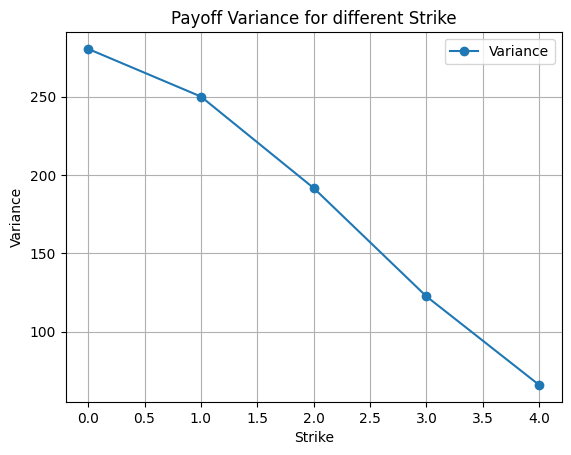

In [5]:
# Plot the computation time for different strike prices
fig, ax = plt.subplots()

ax.plot(result.index, result['Variance'], marker='o', label = 'Variance')
ax.set_title('Payoff Variance for different Strike')
ax.legend()
ax.set_xlabel('Strike')
ax.set_ylabel('Variance')
ax.grid(True)
plt.show()

#### Why the Variance Decreases as the Strike Price Increases

As the strike price $K$ increases, the option becomes less likely to end up **in the money**. 
This means that the payoff $\max(\bar{S}_T - K, 0)$ is equal to zero for a larger proportion of 
simulated scenarios. Consequently, the distribution of payoffs becomes more concentrated around zero, 
reducing its overall variability. In other words, when $K$ is high, most simulations produce either 
a small or null payoff, leading to a **lower variance** in the Monte Carlo estimates. Conversely, for 
lower strike prices, the option has a higher probability of a positive payoff, which introduces greater 
dispersion and thus higher variance.


## Pricing Basket Options Using PyTorch

In order to leverage the **parallel computing power of GPUs**, let's implement the same algorithm using **PyTorch**. This will allow us to run simulations on the GPU and achieve significantly faster computations. Moreover, PyTorch provides efficient tensor operations and automatic differentiation, making it an ideal framework for large-scale simulations and optimization tasks.

In [6]:
# PyTorch versions of simulate_paths and payoff
def simulate_paths_torch(n_paths, L):
    """Generate correlated Gaussian vectors using Cholesky decomposition."""
    d = cor.shape[0]
    G = torch.randn((n_paths, d), device=device)
    return G @ L.T

def payoff_basket_torch(S0, K, r, t, sigma, G_corr):
    """Compute discounted basket payoff."""
    S0 = torch.tensor(S0, device=device)
    sigma = torch.tensor(sigma, device=device)
    St = S0 * torch.exp((r - 0.5 * sigma**2) * t + torch.sqrt(torch.tensor(t, device=device)) * G_corr * sigma)
    payoff = torch.clamp(torch.mean(St, dim=1) - K, min=0)
    return torch.exp(torch.tensor(-r*t, device=device)) * payoff

def basket_mc_torch(S0, K, r, t, cor, sigma, e, proba, batch_size=1000_000):
    """
    Efficient adaptive Monte Carlo pricing for a basket option using antithetic variates.
    Only running sums are kept to save memory.
    """
    start = time.perf_counter()
    n_total = 0
    mean_sum = 0.0
    sq_sum = 0.0
    z = sps.norm.ppf(1 - (1 - proba) / 2)
    ci_halfwidth = float('inf')  # initialize
    L = torch.linalg.cholesky(torch.tensor(cor, device=device))

    
    while ci_halfwidth > e or n_total < batch_size:
        # Generate batch
        G_corr = simulate_paths_torch(batch_size, L)
        
        # Compute batch payoffs
        batch_payoff = payoff_basket_torch(S0, K, r, t, sigma, G_corr)
        
        # Update running sums
        batch_mean = batch_payoff.mean().item()
        batch_sq_sum = (batch_payoff ** 2).sum().item()
        batch_n = batch_payoff.numel()
        
        # Combine with previous batches
        old_n = n_total
        n_total += batch_n
        mean_sum += batch_mean * batch_n
        sq_sum += batch_sq_sum
        
        mean = mean_sum / n_total
        var = (sq_sum / n_total) - mean**2
        std = np.sqrt(var)
        ci_halfwidth = z * std / np.sqrt(n_total)
        
    elapsed = time.perf_counter() - start
    return {
        "Estimated price": mean,
        "Variance": var,
        "Lower CI": mean - ci_halfwidth,
        "Upper CI": mean + ci_halfwidth,
        "CI width": 2 * ci_halfwidth,
        "Simulations": n_total,
        "Elapsed time (s)": elapsed,
        "Strike": K
    }

### PyTorch using CPU

In [7]:
result_torch = []

# Set device on CPU
device = torch.device("cpu")

#Change default type from float32 to float64 to compare with Numpy
torch.set_default_dtype(torch.float64)

for k in K:
    p = basket_mc_torch(S0, k, r, T,cor, sigma, 0.005, 0.95, 5000_000)
    result_torch.append(p)
    
result_torch = pd.DataFrame(result_torch)
result_torch

,Estimated price,Variance,Lower CI,Upper CI,CI width,Simulations,Elapsed time (s),Strike
0,27.765297,280.503086,27.760404,27.770191,0.009787,45000000,57.190283,80.0
1,19.393278,249.932408,19.388378,19.398177,0.009798,40000000,51.127110,90.0
2,12.266946,191.680325,12.261992,12.271900,0.009908,30000000,38.010146,100.0
3,6.961647,122.593739,6.956795,6.966500,0.009705,20000000,24.431402,110.0
4,3.554202,66.024172,3.550090,3.558314,0.008224,15000000,17.838925,120.0


### PyTorch using GPU

In [8]:
result_torch_gpu = []

# Set device on GPU
device = torch.device("cuda:0")

for k in K:
    p = basket_mc_torch(S0, k, r, T,cor, sigma, 0.005, 0.95, 5000_000)
    result_torch_gpu.append(p)
    torch.cuda.empty_cache() # Release cached memory

result_torch_gpu = pd.DataFrame(result_torch_gpu)
result_torch_gpu


,Estimated price,Variance,Lower CI,Upper CI,CI width,Simulations,Elapsed time (s),Strike
0,27.769090,280.546708,27.764196,27.773983,0.009788,45000000,11.899754,80.0
1,19.396527,250.067930,19.391627,19.401428,0.009801,40000000,8.833347,90.0
2,12.265049,191.701908,12.260094,12.270003,0.009909,30000000,6.793081,100.0
3,6.963011,122.660105,6.958157,6.967865,0.009708,20000000,4.584704,110.0
4,3.553211,65.871322,3.549104,3.557319,0.008214,15000000,3.678079,120.0


### Performance Comparison between NumpPy, PyTorch (CPU) and PyTorch (GPU)

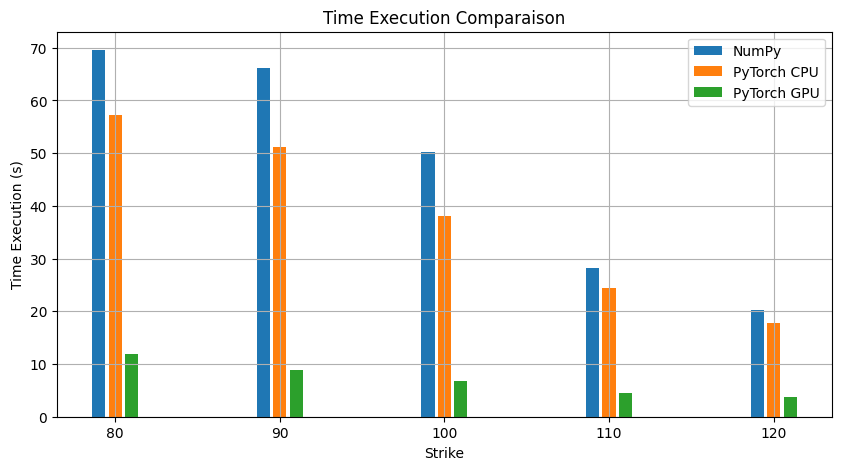

In [9]:
methods = {
    "Classic NumPy": result["Elapsed time (s)"],
    "Torch CPU": result_torch["Elapsed time (s)"],
    "Torch GPU": result_torch_gpu["Elapsed time (s)"]
}
x = np.arange(len(K))  # x positions for strikes
bar_width = 1

fig, ax = plt.subplots(figsize=(10,5))

ax.bar(K - bar_width, methods['Classic NumPy'], label='NumPy')
ax.bar(K, methods['Torch CPU'], label = 'PyTorch CPU')
ax.bar(K + bar_width, methods['Torch GPU'], label = 'PyTorch GPU')
ax.set_title('Time Execution Comparaison')
ax.grid(True)
ax.legend()
ax.set_xlabel('Strike')
ax.set_ylabel('Time Execution (s)')

plt.show()

The bar chart above compares the execution times of the same algorithm implemented using **NumPy**, **PyTorch on CPU**, and **PyTorch on GPU** for different strike values. Both NumPy and PyTorch were configured to use 64-bit precision (float64) to ensure a fair comparison (default is float32 for PyTorch). The results show that PyTorch on CPU slightly outperforms NumPy. The real performance breakthrough, however, comes from using **PyTorch on GPU**, where execution times drop dramatically to below 15 seconds across all strikes. This clearly illustrates **the advantage of GPU parallelization** for large-scale simulations and highlights PyTorch’s suitability for computationally intensive numerical tasks.

For the next step, because **PyTorch on CPU** and **NumPy exhibit** similar performance, we will focus solely on using **PyTorch with GPU** to evaluate GPU performance.

## Variance Reduction with Antithetic Variables

Monte Carlo simulations often suffer from high variance, which slows convergence.  
One techniques to reduce variance without changing the estimator’s bias is the **Antithetic Variables Method**.

### 1. Principle

Let $ X $ be a random variable with expectation $ \mathbb{E}[X] = \mu $ and variance $ \text{Var}(X) = \sigma_X^2 $.

We can generate a second random variable $ X' $ such that:
- $ X' $ has the **same distribution** as $ X $,
- $ X $ and $ X' $ are **negatively correlated**: $ \text{Cov}(X, X') < 0 $.

Then we define the **antithetic estimator**:
$$
\chi = \frac{X + X'}{2}.
$$

Its variance is:
$$
\text{Var}(\chi) = \frac{\text{Var}(X) + \text{Cov}(X, X')}{2}.
$$

If $ \text{Cov}(X, X') < 0 $, then $ \text{Var}(\chi) < \text{Var}(X) $,  
which means the estimator converges faster for the same computational effort.

### 2. Application to Monte Carlo Simulation

In our case, $ X $ corresponds to the simulated payoff of the basket option.  
We generate a vector of standard normal variables $ G $ and construct its **antithetic counterpart** $ -G $:
- Both have the **same mean (0)** and **variance (1)**.
- They are perfectly **negatively correlated**: $ \text{Corr}(G, -G) = -1 $.

Thus, if the payoff function $ f $ is **monotonic** with respect to $ G $,  
then $ f(G) $ and $ f(-G) $ will also be negatively correlated, satisfying the key hypothesis:
$$
\text{Cov}(f(G), f(-G)) < 0.
$$

### 3. Implementation Summary

In the code:
1. We generate correlated standard normals `G_corr = G @ L` (using Cholesky).
2. We create their antithetic counterparts `G_corr_neg = -G_corr`.
3. We simulate both sets of terminal prices `S_T` and `S_T_neg`.
4. We compute the payoffs for both paths and average them:
   $$
   \text{payoff}_{\text{antithetic}} = \frac{1}{2}(\text{payoff}(G) + \text{payoff}(-G)).
   $$
5. Finally, we estimate the mean and a confidence interval using the Central Limit Theorem.

### 4. Advantages

- **No additional random draws**: the antithetic samples are obtained by simple negation.
- **Reduced variance**: the estimator uses negative correlation to stabilize results.
- **Same bias and convergence** as the standard Monte Carlo method, but with higher efficiency.

In summary, this method leverages the monotonicity of the payoff and the symmetry of the normal distribution to produce **more accurate estimates with the same computational effort**.


In [10]:
def basket_mc_antithetic(S0, K, r, t, cor, sigma, rng, e, proba, batch_size=1000_000):
    """
    Adaptive Monte Carlo pricing for a basket option using antithetic variates.
    The number of samples increases until the confidence interval width
    is smaller than the target precision 'e'.
    """
    start = time.perf_counter()
    n_total = 0
    mean_sum = 0.0
    sq_sum = 0.0
    z = sps.norm.ppf(1 - (1 - proba)/2)
    ci_halfwidth = float('inf')  # ensure loop runs
    L = np.linalg.cholesky(cor)
    
    while ci_halfwidth > e:
        # Generate a batch of correlated paths
        G_corr = simulate_paths(batch_size, L)
        G_corr_neg = -G_corr  # antithetic
        
        # Compute batch payoffs
        batch_payoff = payoff_basket(S0, K, r, t, sigma, G_corr)
        batch_payoff_neg = payoff_basket(S0, K, r, t, sigma, G_corr_neg)
        batch_payoff_antithetic = 0.5 * (batch_payoff + batch_payoff_neg)
        
        # Update running sums
        batch_mean = batch_payoff_antithetic.mean()
        batch_sq_sum = np.sum(batch_payoff_antithetic**2)
        batch_n = len(batch_payoff_antithetic)
        
        n_total += batch_n
        mean_sum += batch_mean * batch_n
        sq_sum += batch_sq_sum
        
        # Compute mean, variance, confidence interval
        mean = mean_sum / n_total
        var = (sq_sum / n_total) - mean**2
        std = np.sqrt(var)
        ci_halfwidth = z * std / np.sqrt(n_total)

    elapsed = time.perf_counter() - start
    
    return {
        "Estimated price": mean,
        "Variance": var,
        "Lower CI": mean - ci_halfwidth,
        "Upper CI": mean + ci_halfwidth,
        "CI width": 2 * ci_halfwidth,
        "Simulations": n_total,
        "Elapsed time (s)": elapsed,
        "Strike": K
    }

### Example

In [11]:
results_antithetic = []

for k in K:
    res = basket_mc_antithetic(S0, k, r, T, cor, sigma, rng, e=0.005, proba=0.95)
    results_antithetic.append(res)

results_antithetic = pd.DataFrame(results_antithetic)
results_antithetic

,Estimated price,Variance,Lower CI,Upper CI,CI width,Simulations,Elapsed time (s),Strike
0,27.769828,7.614586,27.766004,27.773653,0.007649,2000000,4.674223,80.0
1,19.394169,15.697276,19.389685,19.398652,0.008967,3000000,6.512787,90.0
2,12.271450,29.519072,12.266688,12.276213,0.009525,5000000,10.879452,100.0
3,6.960533,37.097182,6.955660,6.965407,0.009747,6000000,15.626257,110.0
4,3.556299,26.687028,3.551771,3.560827,0.009056,5000000,11.986067,120.0


### Antithetic Variables Method using PyTorch

In [12]:
def basket_mc_antithetic_torch(S0, K, r, t, cor, sigma, e, proba, batch_size=50_000):
    """
    Efficient adaptive Monte Carlo pricing for a basket option using antithetic variates.
    Only running sums are kept to save memory.
    """
    start = time.perf_counter()
    n_total = 0
    mean_sum = 0.0
    sq_sum = 0.0
    z = sps.norm.ppf(1 - (1 - proba) / 2)
    ci_halfwidth = float('inf')  # initialize
    L = torch.linalg.cholesky(torch.tensor(cor, device=device))
    
    while ci_halfwidth > e or n_total < batch_size:
        # Generate batch
        G_corr = simulate_paths_torch(batch_size, L)
        G_corr_neg = -G_corr  # antithetic
        
        # Compute batch payoffs
        batch_payoff = payoff_basket_torch(S0, K, r, t, sigma, G_corr)
        batch_payoff_neg = payoff_basket_torch(S0, K, r, t, sigma, G_corr_neg)
        batch_payoff_antithetic = 0.5 * (batch_payoff + batch_payoff_neg)
        
        # Update running sums
        batch_mean = batch_payoff_antithetic.mean().item()
        batch_sq_sum = (batch_payoff_antithetic ** 2).sum().item()
        batch_n = batch_payoff_antithetic.numel()
        
        # Combine with previous batches
        old_n = n_total
        n_total += batch_n
        delta = batch_mean - mean_sum / (old_n if old_n > 0 else 1)
        mean_sum += batch_mean * batch_n
        sq_sum += batch_sq_sum
        
        mean = mean_sum / n_total
        var = (sq_sum / n_total) - mean**2
        std = np.sqrt(var)
        ci_halfwidth = z * std / np.sqrt(n_total)
        
    elapsed = time.perf_counter() - start
    
    return {
        "Estimated price": mean,
        "Variance": var,
        "Lower CI": mean - ci_halfwidth,
        "Upper CI": mean + ci_halfwidth,
        "CI width": 2 * ci_halfwidth,
        "Simulations": n_total,
        "Elapsed time (s)": elapsed,
        "Strike": K
    }


In [13]:
results_torch_antithetic = []

# Set device on GPU
device = torch.device("cuda:0")

for k in K:
    res = basket_mc_antithetic_torch(S0, k, r, T, cor, sigma, e=0.005, proba=0.95, batch_size=100_000)
    results_torch_antithetic.append(res)
    torch.cuda.empty_cache() # Release cached memory
    
results_torch_antithetic = pd.DataFrame(results_torch_antithetic)
results_torch_antithetic

,Estimated price,Variance,Lower CI,Upper CI,CI width,Simulations,Elapsed time (s),Strike
0,27.768037,7.600459,27.763104,27.772969,0.009865,1200000,0.546769,80.0
1,19.396020,15.694691,19.391109,19.400931,0.009822,2500000,0.476119,90.0
2,12.261124,29.361781,12.256172,12.266076,0.009904,4600000,0.841367,100.0
3,6.961743,37.081802,6.956744,6.966742,0.009998,5700000,1.029509,110.0
4,3.554057,26.681635,3.549117,3.558997,0.009880,4200000,0.773033,120.0


### Performance Comparaison

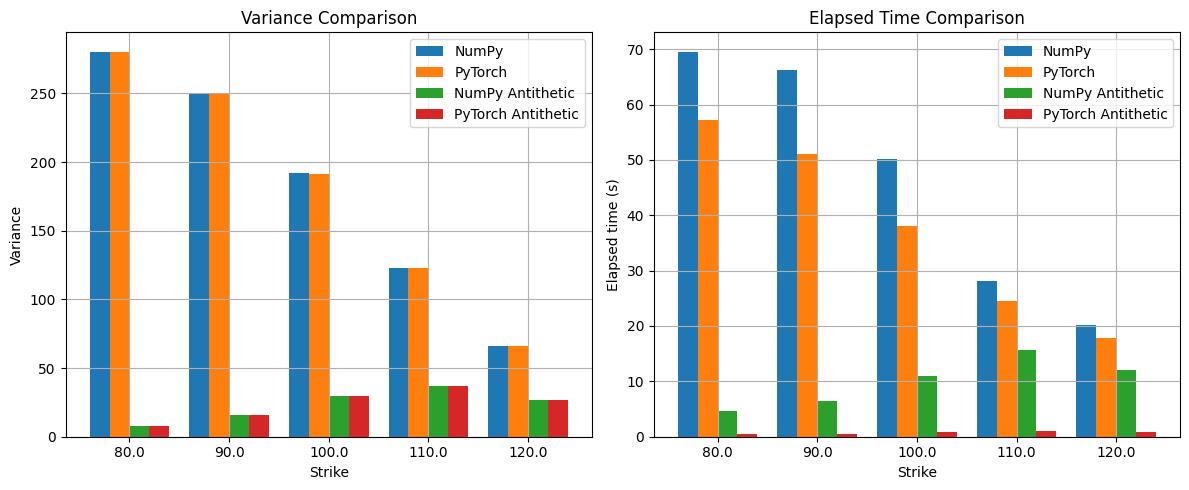

In [14]:
# Methods and variables to compare
methods_variance = {
    "NumPy": result["Variance"],
    "PyTorch": result_torch["Variance"],
    "NumPy Antithetic": results_antithetic["Variance"],
    "PyTorch Antithetic": results_torch_antithetic["Variance"],
}

methods_elapsed = {
    "NumPy": result["Elapsed time (s)"],
    "PyTorch": result_torch["Elapsed time (s)"],
    "NumPy Antithetic": results_antithetic["Elapsed time (s)"],
    "PyTorch Antithetic": results_torch_antithetic["Elapsed time (s)"],
}

x = np.arange(len(K))
bar_width = 0.2
labels = list(methods_variance.keys())

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Variance plot
for i, label in enumerate(labels):
    axes[0].bar(x + i * bar_width, methods_variance[label], width=bar_width, label=label)
axes[0].set_title('Variance Comparison')
axes[0].set_xlabel('Strike')
axes[0].set_ylabel('Variance')
axes[0].set_xticks(x + 1.5 * bar_width)
axes[0].set_xticklabels(K)
axes[0].grid(True)
axes[0].legend()

# Elapsed time plot
for i, label in enumerate(labels):
    axes[1].bar(x + i * bar_width, methods_elapsed[label], width=bar_width, label=label)
axes[1].set_title('Elapsed Time Comparison')
axes[1].set_xlabel('Strike')
axes[1].set_ylabel('Elapsed time (s)')
axes[1].set_xticks(x + 1.5 * bar_width)
axes[1].set_xticklabels(K)
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

## Control Variate Method for a Basket Option

We aim to estimate the price of a basket option using Monte Carlo simulations with a **control variate** based on the geometric payoff.

### 1. Geometric Payoff (Control Variate)

We define a **geometric payoff** whose price is known analytically:

$$
Y = \Big( \bar{S} \, e^Z - K \Big)^+
$$

with

$$
Z = \sum_{i=1}^{d} w_i \left( \mu_i T + \sigma_i \sqrt{T} \, G_i \right)
$$

where:  
- $ w_i = \frac{S_i(0)}{\sum_j S_j(0)} $ are the basket weights  
- $ \mu_i = r - \frac{1}{2} \sigma_i^2 $

We also define:

$$
m = \sum_i w_i (r - \frac{1}{2}\sigma_i^2), \quad
s^2 = \sum_j \big[ (w \odot \sigma) L \big]_j^2, \quad
\rho = m + \frac{1}{2}s^2
$$

The theoretical price of the geometric payoff is given by the **Black–Scholes formula**:

$$
\mathbb{E}[Y] = e^{\rho T} \, BS(\bar{S}, K, s, \rho, T)
$$

### 2. Control Variate

We construct the variance-reduced estimator:

$$
\hat{X} = X - \lambda (Y - \mathbb{E}[Y])
$$

with the optimal coefficient:

$$
\lambda = \frac{\operatorname{Cov}(X, Y)}{\operatorname{Var}(Y)}
$$

This correction reduces the variance of the Monte Carlo estimator while keeping it unbiased.


In [15]:
def BS(S0, K, sigma, r, t):
    d1 = (np.log(S0/K) + (r + 0.5 * sigma ** 2) * t)/(sigma * np.sqrt(t))
    d2 = d1 - sigma * np.sqrt(t)

    return S0 * sps.norm.cdf(d1) - K * np.exp(-r*t)*sps.norm.cdf(d2)

In [16]:
def payoff_control_variate(S0, K, r, t, sigma, weight, G_corr, L):
    """Geomtric payoff used as a control variate"""
    m = (weight * (r - 0.5 * sigma ** 2)).sum()
    s2 = (((weight * sigma) @ L) ** 2).sum()
    rho = m + 0.5 * s2
    
    mu_T = (r - 0.5 * sigma ** 2) * t
    sig_T = sigma * np.sqrt(t)  
    
    Z = np.sum(weight[:, None] * (mu_T[:, None] + sig_T[:, None] * G_corr.T), axis=0)
    
    # Simulated payoff
    S_bar = S0.mean()
    Y = np.maximum(S_bar * np.exp(Z) - K, 0)
    
    # Black-Scholes Prices of Y - E[Y]
    s_geo = np.sqrt(s2)
    Y_mean = np.exp(rho * t) * BS(S_bar, K, s_geo, rho, t)
    
    return Y - Y_mean
    
def basket_mc_batch(S0, K, r, t, cor, sigma, rng, e, proba, batch_size=100_000):
    start = time.perf_counter()
    n_total = 0
    mean_sum = 0.0
    sq_sum = 0.0

    weight = S0 / np.sum(S0)
    z = sps.norm.ppf(1 - (1 - proba) / 2)
    ci_halfwidth = float("inf")

    L = np.linalg.cholesky(cor)

    while ci_halfwidth > e:
        # Path Generation
        G_corr = simulate_paths(batch_size, L)

        # Basket option payoff
        batch_payoff_x = payoff_basket(S0, K, r, t, sigma, G_corr)

        # Control variate payoff
        batch_payoff_y = payoff_control_variate(S0, K, r, t, sigma, weight, G_corr, L)

        # Optimal lambda to minimize
        cov_xy = np.cov(batch_payoff_x, batch_payoff_y, ddof=1)[0, 1]
        var_y = np.var(batch_payoff_y, ddof=1)
        lam = cov_xy / var_y

        # Payoff corrected
        batch_payoff = batch_payoff_x - lam * (batch_payoff_y)

        # Updating results
        batch_mean = batch_payoff.mean()
        batch_sq_sum = np.sum(batch_payoff ** 2)
        batch_n = len(batch_payoff)

        n_total += batch_n
        mean_sum += batch_mean * batch_n
        sq_sum += batch_sq_sum

        # Statistics
        mean = mean_sum / n_total
        var = (sq_sum / n_total) - mean ** 2
        std = np.sqrt(var)
        ci_halfwidth = z * std / np.sqrt(n_total)

    elapsed = time.perf_counter() - start

    return {
        "Estimated price": mean,
        "Variance": var,
        "Lower CI": mean - ci_halfwidth,
        "Upper CI": mean + ci_halfwidth,
        "CI width": 2 * ci_halfwidth,
        "Simulations": n_total,
        "Elapsed time (s)": elapsed,
        "Strike": K,
    }

In [17]:
result_control = []
for k in K:
    p_batch = basket_mc_batch(S0, k, r, T,cor, sigma, rng, 0.005, 0.95, 10000)
    result_control.append(p_batch)
result_control = pd.DataFrame(result_control)
result_control

,Estimated price,Variance,Lower CI,Upper CI,CI width,Simulations,Elapsed time (s),Strike
0,27.769336,0.663981,27.764520,27.774151,0.009631,110000,0.230989,80.0
1,19.395769,1.065549,19.390862,19.400676,0.009814,170000,0.333080,90.0
2,12.263759,1.505825,12.258849,12.268668,0.009819,240000,0.500453,100.0
3,6.964302,1.635906,6.959386,6.969218,0.009833,260000,0.495504,110.0
4,3.554022,1.344206,3.549064,3.558981,0.009917,210000,0.399395,120.0


### Control Variate with PyTorch

In [18]:
import math

def BS_torch(S0, K, sigma, r, t):
    # Calcul des termes d1 et d2
    d1 = (torch.log(S0 / K) + (r + 0.5 * sigma**2) * t) / (sigma * torch.sqrt(t))
    d2 = d1 - sigma * torch.sqrt(t)

    # CDF de la loi normale standard via erf
    def norm_cdf(x):
        return 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

    Nd1 = norm_cdf(d1)
    Nd2 = norm_cdf(d2)

    # Formule Black-Scholes
    call_price = S0 * Nd1 - K * torch.exp(-r * t) * Nd2
    return call_price

In [19]:
def payoff_control_variate_torch(S0, K, r, t, sigma, weight, G_corr, L):
    m = (weight * (r - 0.5 * sigma ** 2)).sum()
    s2 = ((weight * sigma) @ L).pow(2).sum()
    rho = m + 0.5 * s2

    mu_T = (r - 0.5 * sigma ** 2) * t
    sig_T = sigma * torch.sqrt(t) 

    Z = (weight[:, None] * (mu_T[:, None] + sig_T[:, None] * G_corr.T)).sum(dim=0)
    
    S_bar = S0.mean()
    Y = torch.maximum(S_bar * torch.exp(Z) - K, torch.tensor(0.0, device=device))
    
    s_geo = torch.sqrt(s2)
    Y_mean = torch.exp(rho * t) * BS_torch(S_bar, K, s_geo, rho, t)
        
    return Y - Y_mean

def payoff_basket_torch(S0, K, r, t, sigma, G_corr):
    """Compute discounted basket payoff."""
    St = S0 * torch.exp((r - 0.5 * sigma**2) * t + torch.sqrt(t) * G_corr * sigma)
    payoff = torch.clamp(torch.mean(St, dim=1) - K, min=0)
    return torch.exp(-r*t) * payoff
    
def basket_mc_batch_torch(S0, K, r, t, cor, sigma, e, proba, batch_size=100_000, device='cpu'):
  
    start = time.perf_counter()
    n_total = 0
    mean_sum = 0.0
    sq_sum = 0.0
    
    weight = S0 / S0.sum()
    z = sps.norm.ppf(1 - (1 - proba) / 2)
    ci_halfwidth = float("inf")

    S0 = torch.as_tensor(S0, dtype=torch.float64, device=device)
    K = torch.as_tensor(K, device=device)
    r = torch.as_tensor(r, device=device)
    t = torch.as_tensor(t, device=device)
    sigma = torch.as_tensor(sigma, device=device)
    weight = torch.as_tensor(weight, device=device)

    cor = torch.as_tensor(cor, device=device)
    L = torch.linalg.cholesky(cor)
    
    while ci_halfwidth > e:
        # Path Generations
        G_corr = simulate_paths_torch(batch_size, L)
        
        # arithmetic Payoff 
        batch_payoff_x = payoff_basket_torch(S0, K, r, t, sigma, G_corr)
        
        # Geometric Payoff
        batch_payoff_y = payoff_control_variate_torch(S0, K, r, t, sigma, weight, G_corr, L)
        
        # Control Variable
        cov_matrix = torch.cov(torch.stack((batch_payoff_x, batch_payoff_y)))
        cov_xy = cov_matrix[0, 1]
        var_y = cov_matrix[1, 1]
        lam = cov_xy / var_y
        
        # Correction du payoff
        batch_payoff = batch_payoff_x - lam * batch_payoff_y
        
        # Mise à jour des moyennes
        batch_mean = batch_payoff.mean().item()
        batch_sq_sum = (batch_payoff ** 2).sum().item()
        batch_n = len(batch_payoff)
        
        n_total += batch_n
        mean_sum += batch_mean * batch_n
        sq_sum += batch_sq_sum
        
        # Statistiques cumulées
        mean = mean_sum / n_total
        var = (sq_sum / n_total) - mean ** 2
        std = np.sqrt(var)
        ci_halfwidth = z * std / np.sqrt(n_total)
    
    elapsed = time.perf_counter() - start
    
    return {
        "Estimated price": mean,
        "Variance": var,
        "Lower CI": mean - ci_halfwidth,
        "Upper CI": mean + ci_halfwidth,
        "CI width": 2 * ci_halfwidth,
        "Simulations": n_total,
        "Elapsed time (s)": elapsed,
        "Strike": K.item(),
    }

In [20]:
results_torch_control = []

for k in K:
    res = basket_mc_batch_torch(S0, k, r, T, cor, sigma, e=0.005, proba=0.95, batch_size=10_000, device='cuda')
    results_torch_control.append(res)
    torch.cuda.empty_cache() # Release cached memory
    
results_torch_control = pd.DataFrame(results_torch_control)
results_torch_control

,Estimated price,Variance,Lower CI,Upper CI,CI width,Simulations,Elapsed time (s),Strike
0,27.767901,0.667207,27.763074,27.772728,0.009654,110000,0.273177,80.0
1,19.394995,1.060489,19.390100,19.399890,0.009791,170000,0.234354,90.0
2,12.268437,1.507372,12.263525,12.273349,0.009824,240000,0.276692,100.0
3,6.960811,1.631202,6.955902,6.965720,0.009819,260000,0.213246,110.0
4,3.553074,1.344000,3.548116,3.558033,0.009917,210000,0.127015,120.0


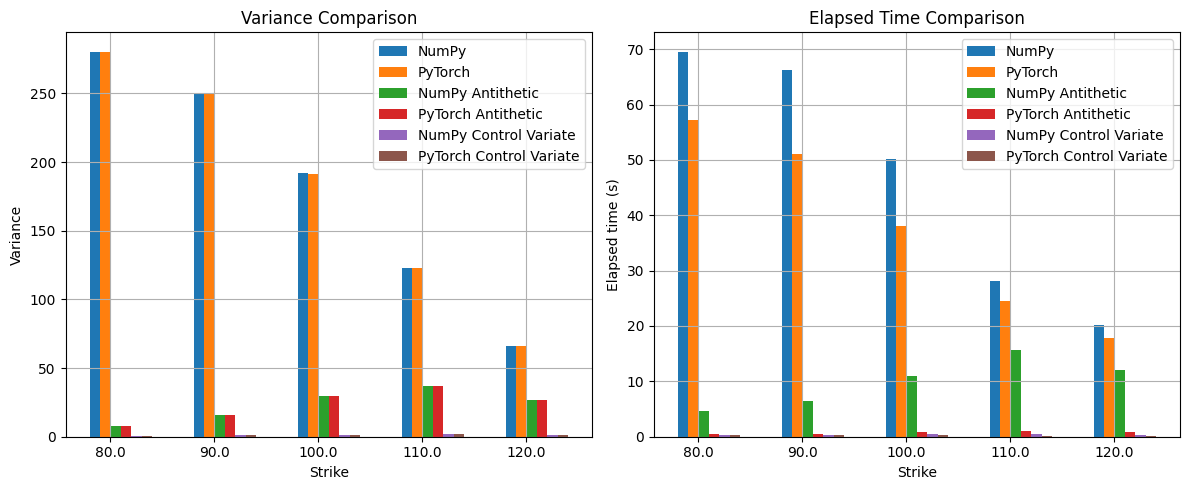

In [21]:
# Methods and variables to compare
methods_variance = {
    "NumPy": result["Variance"],
    "PyTorch": result_torch["Variance"],
    "NumPy Antithetic": results_antithetic["Variance"],
    "PyTorch Antithetic": results_torch_antithetic["Variance"],
    "NumPy Control Variate": result_control["Variance"],
    "PyTorch Control Variate": results_torch_control["Variance"],
}

methods_elapsed = {
    "NumPy": result["Elapsed time (s)"],
    "PyTorch": result_torch["Elapsed time (s)"],
    "NumPy Antithetic": results_antithetic["Elapsed time (s)"],
    "PyTorch Antithetic": results_torch_antithetic["Elapsed time (s)"],
    "NumPy Control Variate": result_control["Elapsed time (s)"],
    "PyTorch Control Variate": results_torch_control["Elapsed time (s)"],
}

x = np.arange(len(K))
bar_width = 0.1
labels = list(methods_variance.keys())

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Variance plot
for i, label in enumerate(labels):
    axes[0].bar(x + i * bar_width, methods_variance[label], width=bar_width, label=label)
axes[0].set_title('Variance Comparison')
axes[0].set_xlabel('Strike')
axes[0].set_ylabel('Variance')
axes[0].set_xticks(x + 1.5 * bar_width)
axes[0].set_xticklabels(K)
axes[0].grid(True)
axes[0].legend()

# Elapsed time plot
for i, label in enumerate(labels):
    axes[1].bar(x + i * bar_width, methods_elapsed[label], width=bar_width, label=label)
axes[1].set_title('Elapsed Time Comparison')
axes[1].set_xlabel('Strike')
axes[1].set_ylabel('Elapsed time (s)')
axes[1].set_xticks(x + 1.5 * bar_width)
axes[1].set_xticklabels(K)
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

## Combining Antithetic and Control Variate Methods

We can combine **Antithetic** and **Control Variate** methods to enhance the performance of Monte Carlo estimators.

Let:
- $Y$ be the random variable of interest,
- $X$ be a control variable correlated with $Y$.

### Control Variate Estimator
The **Control Variate** estimator is defined as:

$$
\hat{\mu}_{\text{CV}} = \frac{1}{n} \sum_{i=1}^n \left( Y_i - \lambda (X_i - \mathbb{E}[X]) \right),
$$

where the coefficient $\lambda$ is optimized as follows:

$$
\lambda = \frac{\text{Cov}(Y, X)}{\text{Var}(X)}.
$$

### Integration of the Antithetic Method
To integrate the **Antithetic** method, we generate pairs of negatively correlated random variables, $(Y_i, Y_i^A)$, where $Y_i^A$ is the antithetic variable associated with $Y_i$.

The combined estimator then becomes:

$$
\hat{\mu}_{\text{CV+A}} = \frac{1}{2n} \sum_{i=1}^n \left( (Y_i - \lambda (X_i - \mathbb{E}[X])) + (Y_i^A - \lambda (X_i^A - \mathbb{E}[X])) \right).
$$

### Advantages
This approach combines:
- The variance reduction of **Control Variates**,
- The efficiency of **Antithetic Variates**.

Empirical results show a significant reduction in variance and optimized computation time, as illustrated in the next plots.


In [22]:
def basket_mc_antithetic_control(S0, K, r, t, cor, sigma, e=0.005, proba=0.95, batch_size=100_000, device='cpu'):
    device = torch.device(device)
    start = time.perf_counter()

    # Convert inputs to tensors
    S0 = torch.as_tensor(S0, dtype=torch.float64, device=device)
    K = torch.as_tensor(K, device=device)
    r = torch.as_tensor(r, device=device)
    t = torch.as_tensor(t, device=device)
    sigma = torch.as_tensor(sigma, device=device)
    weight = S0 / S0.sum()
    weight = torch.as_tensor(weight, device=device)
    cor = torch.as_tensor(cor, device=device)
    L = torch.linalg.cholesky(cor)

    z = sps.norm.ppf(1 - (1 - proba)/2)
    ci_halfwidth = float('inf')
    n_total, mean_sum, sq_sum = 0, 0.0, 0.0

    while ci_halfwidth > e:
        # Generate correlated paths
        G_corr = simulate_paths_torch(batch_size, L)

        X1 = payoff_basket_torch(S0, K, r, t, sigma, G_corr)
        X2 = payoff_basket_torch(S0, K, r, t, sigma, -G_corr)
        X = 0.5 * (X1+X2)

        
        # Payoffs Control
        Y1 = payoff_control_variate_torch(S0, K, r, t, sigma, weight, G_corr, L)
        Y2 = payoff_control_variate_torch(S0, K, r, t, sigma, weight, -G_corr, L)
        Y = 0.5 * (Y1+Y2)
        
        # Control variate
        cov_matrix = torch.cov(torch.stack((X, Y)))
        cov_xy = cov_matrix[0, 1]
        var_y = cov_matrix[1, 1]
        lam = cov_xy / var_y

        # Corrected payoff
        X_corr = X - lam * Y

        # Update cumulative statistics
        batch_mean = X_corr.mean().item()
        batch_sq_sum = (X_corr ** 2).sum().item()
        batch_n = len(X_corr)

        n_total += batch_n
        mean_sum += batch_mean * batch_n
        sq_sum += batch_sq_sum

        mean = mean_sum / n_total
        var = (sq_sum / n_total) - mean**2
        std = np.sqrt(var)
        ci_halfwidth = z * std / np.sqrt(n_total)

    elapsed = time.perf_counter() - start

    return {
        "Estimated price": mean,
        "Variance": var,
        "Lower CI": mean - ci_halfwidth,
        "Upper CI": mean + ci_halfwidth,
        "CI width": 2 * ci_halfwidth,
        "Simulations": n_total,
        "Lambda": lam.item(),
        "Elapsed time (s)": elapsed
    }

In [23]:
results_torch_control_antithetic = []
device = 'cuda'
for k in K:
    res = basket_mc_antithetic_control(S0, k, r, T, cor, sigma, e=0.005, proba=0.95, batch_size=3_000, device='cuda')
    results_torch_control_antithetic.append(res)
    torch.cuda.empty_cache() # Release cached memory
    
results_torch_control_antithetic = pd.DataFrame(results_torch_control_antithetic)
results_torch_control_antithetic

,Estimated price,Variance,Lower CI,Upper CI,CI width,Simulations,Lambda,Elapsed time (s)
0,27.768085,0.486442,27.763093,27.773076,0.009983,75000,0.845622,0.195334
1,19.395101,0.522229,19.390125,19.400078,0.009953,81000,0.834871,0.197696
2,12.259428,0.520400,12.254460,12.264396,0.009936,81000,0.865629,0.162803
3,6.957354,0.305171,6.952412,6.962296,0.009884,48000,0.957998,0.089024
4,3.553589,0.525257,3.548597,3.558580,0.009982,81000,1.026961,0.212651


### Results

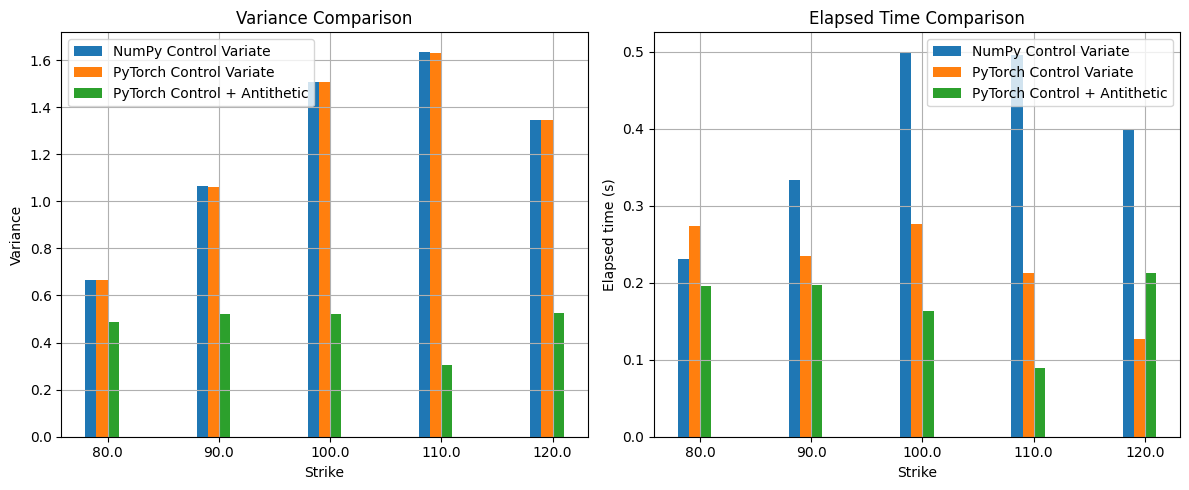

In [24]:
# Methods and variables to compare
methods_variance = {
    "NumPy Control Variate": result_control["Variance"],
    "PyTorch Control Variate": results_torch_control["Variance"],
    "PyTorch Control + Antithetic": results_torch_control_antithetic["Variance"],
}

methods_elapsed = {
    "NumPy Control Variate": result_control["Elapsed time (s)"],
    "PyTorch Control Variate": results_torch_control["Elapsed time (s)"],
    "PyTorch Control + Antithetic": results_torch_control_antithetic["Elapsed time (s)"],
}

x = np.arange(len(K))
bar_width = 0.1
labels = list(methods_variance.keys())

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Variance plot
for i, label in enumerate(labels):
    axes[0].bar(x + i * bar_width, methods_variance[label], width=bar_width, label=label)
axes[0].set_title('Variance Comparison')
axes[0].set_xlabel('Strike')
axes[0].set_ylabel('Variance')
axes[0].set_xticks(x + 1.5 * bar_width)
axes[0].set_xticklabels(K)
axes[0].grid(True)
axes[0].legend()

# Elapsed time plot
for i, label in enumerate(labels):
    axes[1].bar(x + i * bar_width, methods_elapsed[label], width=bar_width, label=label)
axes[1].set_title('Elapsed Time Comparison')
axes[1].set_xlabel('Strike')
axes[1].set_ylabel('Elapsed time (s)')
axes[1].set_xticks(x + 1.5 * bar_width)
axes[1].set_xticklabels(K)
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

The comparative analysis highlights significant differences in performance among the three control methods: NumPy Control Variate, PyTorch Control Variate, and PyTorch Control with Antithetic sampling. In the Variance Comparison, both PyTorch-based methods consistently demonstrate lower variance than the NumPy Control Variate across all Strike values, with the PyTorch Control + Antithetic approach achieving the lowest variance overall. This suggests that the PyTorch implementations, particularly when combined with Antithetic sampling, are more effective at reducing variability in the results.

In terms of Elapsed Time, the NumPy Control Variate method generally requires more computational time compared to the PyTorch methods. The PyTorch Control + Antithetic approach stands out for its efficiency, often achieving the fastest execution times. This indicates that PyTorch-based methods not only improve variance reduction but also offer superior computational performance, making them a preferable choice for applications where both accuracy and speed are critical.

## Conclusion

In this notebook, we developed and compared several **Monte Carlo methods** to price a **European call option on a basket of correlated assets**. Starting from a classical NumPy implementation, we progressively introduced **computational optimizations** and **variance reduction techniques** to improve both **efficiency** and **accuracy**.

#### 1. Adaptive Monte Carlo
We first implemented an adaptive Monte Carlo algorithm that automatically adjusts the number of simulations until a target precision is achieved. This ensured a robust and statistically controlled estimation of the option price, while dynamically managing computational resources.

#### 2. GPU Acceleration with PyTorch
By leveraging **PyTorch** and GPU computation, we significantly reduced execution times from nearly one minute with NumPy to just a few seconds using GPU-based tensors. This highlights the **power of parallelization** for large-scale financial simulations.

#### 3. Variance Reduction Techniques
To enhance estimator stability, we explored two classical variance reduction methods:
- **Antithetic Variables**: reduced variance by exploiting negative correlation between mirrored paths, cutting the number of required simulations by more than half.  
- **Control Variates**: used the analytically known price of a geometric basket as a control, achieving **an order-of-magnitude reduction in variance** while maintaining unbiasedness.

#### 4. Performance and Insights
The comparison between all methods revealed that:
- GPU acceleration offers the largest performance gains.
- Variance reduction techniques dramatically improve convergence for the same level of precision.
- The **Control Variate + GPU** combination is the most efficient, producing stable estimates within milliseconds and minimal variance.

#### 5. Conclusion
This study demonstrates how **combining mathematical rigor with computational efficiency** can yield powerful tools for option pricing. Adaptive Monte Carlo methods ensure accuracy, variance reduction techniques improve convergence, and GPU acceleration provides the computational speed needed for real-world trading and risk management applications.

Future work could extend this framework to **American or Asian options**, or integrate **deep learning–based variance reduction** to further optimize pricing under complex stochastic models.
